In [1]:
# Add the parent directory to the Python path
import sys
import os
parent_dir = os.path.abspath('..')
if parent_dir not in sys.path:
    sys.path.append(parent_dir)

# Import loss function
from texstat.functions import *
import texstat.torch_filterbanks.filterbanks as fb

# Import extra packages
import numpy as np
import librosa
import matplotlib.pyplot as plt
from IPython.display import Audio
import torch
import torch.nn as nn
import torch.optim as optim
import torchaudio
import time
import gc
from tabulate import tabulate  # For creating tables

# Pick device
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

Using device: cuda


In [2]:
# Multiscale Spectrogram Loss for comparison
def multiscale_fft(signal, scales=[4096, 2048, 1024, 512, 256, 128], overlap=.75):
    stfts = []
    for s in scales:
        S = torch.stft(
            signal,
            s,
            int(s * (1 - overlap)),
            s,
            torch.hann_window(s).to(signal),
            True,
            normalized=True,
            return_complex=True,
        ).abs()
        stfts.append(S)
    return stfts

def safe_log(x):
    return torch.log(x + 1e-7)

def multiscale_spectrogram_loss(x, x_hat):
    ori_stft = multiscale_fft(x)
    rec_stft = multiscale_fft(x_hat)
    loss = 0
    for s_x, s_y in zip(ori_stft, rec_stft):
        lin_loss = (s_x - s_y).abs().mean()
        log_loss = (safe_log(s_x) - safe_log(s_y)).abs().mean()
        loss = loss + lin_loss + log_loss
    return loss

In [3]:
# Assuming texstat_loss and multiscale_spectrogram_loss are defined elsewhere
def experiment_noise(audio_path):
    # Device selection
    device = "cuda" if torch.cuda.is_available() else "cpu"

    # Load audio
    y, sr = librosa.load(audio_path, sr=44100, mono=True)

    # Parameters for TexStat
    sr, frame_size = 44100, 2**16
    N_filter_bank = 16
    M_filter_bank = 6
    N_moments = 4
    alpha = torch.tensor([100, 1, 1/10, 1/100], device=device)
    beta = torch.tensor([1, 1, 1, 1, 1], device=device)
    new_sr, new_frame_size = sr // 4, frame_size // 4
    downsampler = torchaudio.transforms.Resample(sr, new_sr).to(device)
    coch_fb = fb.EqualRectangularBandwidth(frame_size, sr, N_filter_bank, 20, sr // 2)
    mod_fb  = fb.Logarithmic(new_frame_size, new_sr, M_filter_bank, 10, new_sr // 4)

    # Make batch of 100 random segments
    segments = []
    for _ in range(100):
        start = np.random.randint(0, len(y) - frame_size)
        segment = y[start:start + frame_size]
        segment = (segment - np.mean(segment)) / np.std(segment)
        segments.append(segment)
    segments = torch.tensor(segments, device=device)

    # Create a batch of 100 random noise segments
    noise = torch.randn(100, frame_size, device=device)

    # Store losses for boxplot
    stats_losses = []
    mss_losses = []
    noise_levels = [i / 10 for i in range(10)]

    stats_mean_std = []  # Store mean ± std for table
    mss_mean_std = []

    for energy in noise_levels:
        stats_loss_i = []
        mss_loss_i = []
        segments_noisy = segments + energy * noise

        for i in range(100):
            segment_local = segments[i]
            segment_noisy_local = segments_noisy[i]

            stats_loss_local = texstat_loss(segment_local, segment_noisy_local, coch_fb, mod_fb, downsampler, N_moments, alpha, beta)
            mss_loss_local   = multiscale_spectrogram_loss(segment_local, segment_noisy_local)

            stats_loss_i.append(stats_loss_local.item())  # Convert to scalar
            mss_loss_i.append(mss_loss_local.item())

        stats_losses.append(stats_loss_i)
        mss_losses.append(mss_loss_i)

        # Calculate mean and std for each noise level
        stats_mean_std.append(f"{np.mean(stats_loss_i):.4f} ± {np.std(stats_loss_i):.4f}")
        mss_mean_std.append(f"{np.mean(mss_loss_i):.4f} ± {np.std(mss_loss_i):.4f}")

    # Create side-by-side boxplots **without outliers**
    plt.figure(figsize=(12, 6))

    # Boxplot for stats loss (no fliers)
    box1 = plt.boxplot(stats_losses, positions=np.arange(len(noise_levels)) - 0.2, widths=0.3, 
                        patch_artist=True, boxprops=dict(facecolor="#3498db", alpha=0.6),
                        showfliers=False)  # Removes outliers

    # Boxplot for MSS loss (no fliers)
    box2 = plt.boxplot(mss_losses, positions=np.arange(len(noise_levels)) + 0.2, widths=0.3, 
                        patch_artist=True, boxprops=dict(facecolor="#e74c3c", alpha=0.6),
                        showfliers=False)  # Removes outliers

    # Labels and styling
    plt.xticks(range(len(noise_levels)), [f"{lvl:.1f}" for lvl in noise_levels])
    plt.xlabel("Noise Energy Level", fontsize=12)
    plt.ylabel("Loss Value", fontsize=12)
    plt.title("Stats Loss & MSS Loss vs Noise Level", fontsize=14, fontweight="bold")
    plt.grid(True, linestyle="--", alpha=0.6)

    # Add legend manually
    plt.legend([box1["boxes"][0], box2["boxes"][0]], ["Stats Loss", "MSS Loss"], loc="upper left")

    # Create table of mean ± std values
    table_data = []
    for i, noise_level in enumerate(noise_levels):
        table_data.append([f"{noise_level:.1f}", stats_mean_std[i], mss_mean_std[i]])

    # Display the table
    table_header = ["Noise Level", "Stats Loss (mean ± std)", "MSS Loss (mean ± std)"]
    table_str = tabulate(table_data, headers=table_header, tablefmt="grid", floatfmt=".4f")

    print(table_str)

    # Show plot
    plt.tight_layout()
    plt.show()

Processing ../../datasets/hand_curated/keyboard/keyboard.wav


/tmp/ipykernel_1732902/2592922352.py:28: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:278.)
  segments = torch.tensor(segments, device=device)


+---------------+---------------------------+-------------------------+
|   Noise Level | Stats Loss (mean ± std)   | MSS Loss (mean ± std)   |
+===============+===========================+=========================+
|        0.0000 | 0.0000 ± 0.0000           | 0.0000 ± 0.0000         |
+---------------+---------------------------+-------------------------+
|        0.1000 | 2.2100 ± 0.7604           | 7.4119 ± 0.5163         |
+---------------+---------------------------+-------------------------+
|        0.2000 | 3.4443 ± 0.8703           | 10.3607 ± 0.6342        |
+---------------+---------------------------+-------------------------+
|        0.3000 | 4.6279 ± 0.8631           | 12.3889 ± 0.6976        |
+---------------+---------------------------+-------------------------+
|        0.4000 | 5.8538 ± 0.8239           | 13.9891 ± 0.7392        |
+---------------+---------------------------+-------------------------+
|        0.5000 | 7.1252 ± 0.7770           | 15.3384 ± 0.7695  

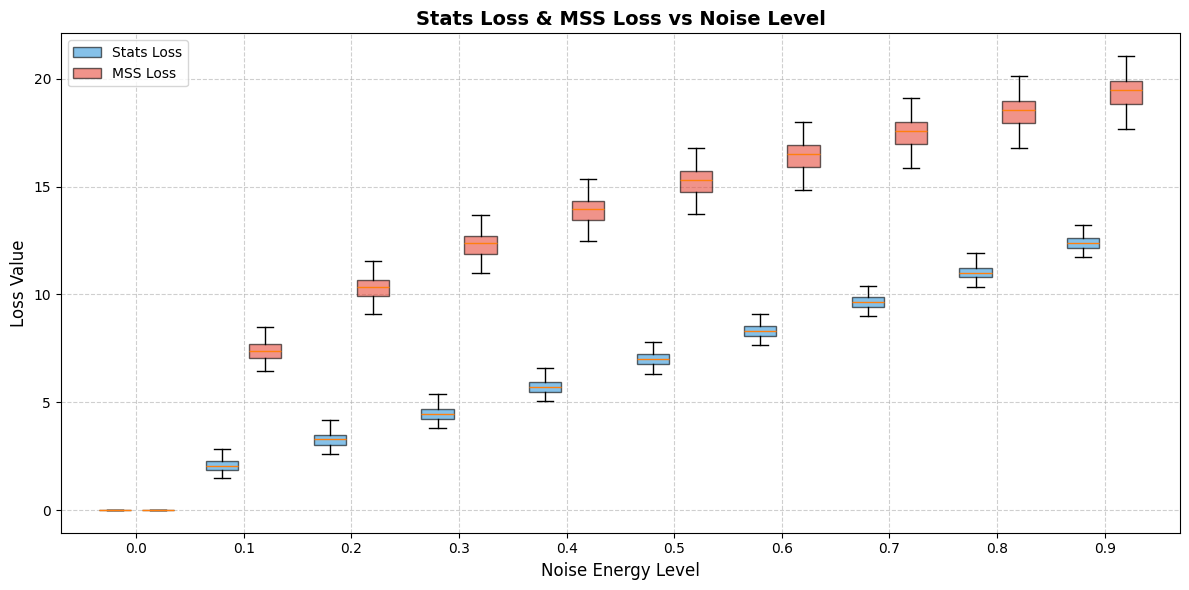

Processing ../../datasets/hand_curated/water/water.wav
+---------------+---------------------------+-------------------------+
|   Noise Level | Stats Loss (mean ± std)   | MSS Loss (mean ± std)   |
+===============+===========================+=========================+
|        0.0000 | 0.0000 ± 0.0000           | 0.0000 ± 0.0000         |
+---------------+---------------------------+-------------------------+
|        0.1000 | 0.4718 ± 0.0418           | 2.9692 ± 0.2669         |
+---------------+---------------------------+-------------------------+
|        0.2000 | 1.3392 ± 0.0720           | 4.7243 ± 0.3666         |
+---------------+---------------------------+-------------------------+
|        0.3000 | 2.3419 ± 0.0943           | 6.1202 ± 0.4245         |
+---------------+---------------------------+-------------------------+
|        0.4000 | 3.4221 ± 0.1141           | 7.3122 ± 0.4625         |
+---------------+---------------------------+-------------------------+
|        

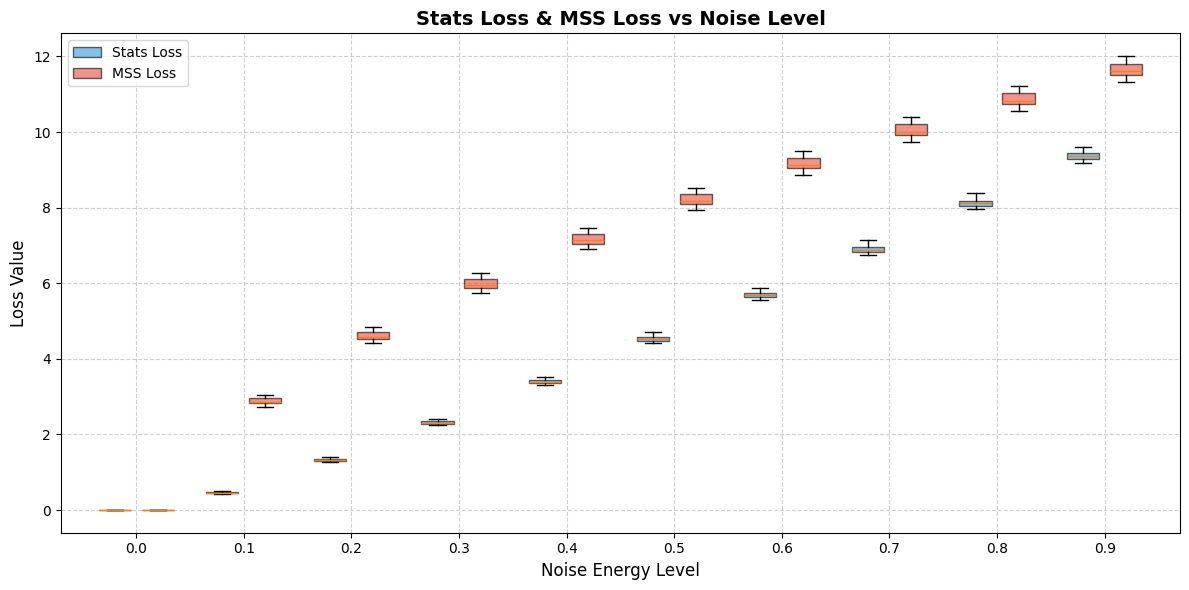

Processing ../../datasets/hand_curated/wind/wind.wav
+---------------+---------------------------+-------------------------+
|   Noise Level | Stats Loss (mean ± std)   | MSS Loss (mean ± std)   |
+===============+===========================+=========================+
|        0.0000 | 0.0000 ± 0.0000           | 0.0000 ± 0.0000         |
+---------------+---------------------------+-------------------------+
|        0.1000 | 1.6720 ± 0.2963           | 13.2719 ± 1.3836        |
+---------------+---------------------------+-------------------------+
|        0.2000 | 3.0914 ± 0.2833           | 17.3621 ± 1.4406        |
+---------------+---------------------------+-------------------------+
|        0.3000 | 4.5144 ± 0.2753           | 19.9576 ± 1.4531        |
+---------------+---------------------------+-------------------------+
|        0.4000 | 5.9409 ± 0.2700           | 21.9107 ± 1.4572        |
+---------------+---------------------------+-------------------------+
|        0.

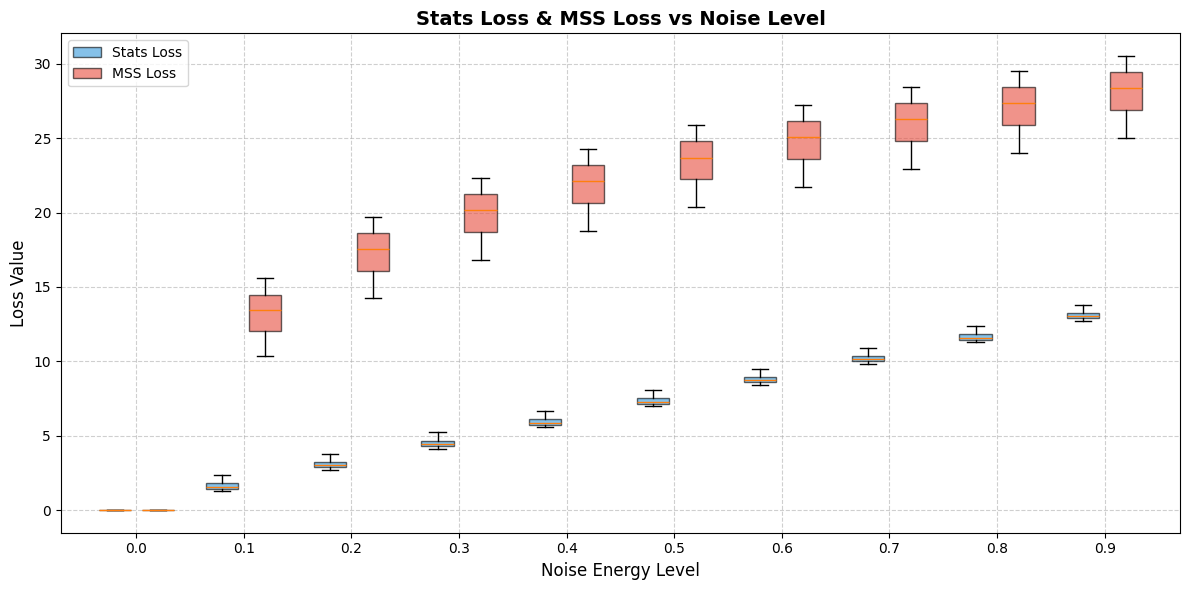

Processing ../../datasets/hand_curated/fire/fire.wav
+---------------+---------------------------+-------------------------+
|   Noise Level | Stats Loss (mean ± std)   | MSS Loss (mean ± std)   |
+===============+===========================+=========================+
|        0.0000 | 0.0000 ± 0.0000           | 0.0000 ± 0.0000         |
+---------------+---------------------------+-------------------------+
|        0.1000 | 3.4271 ± 1.7565           | 14.1802 ± 1.2040        |
+---------------+---------------------------+-------------------------+
|        0.2000 | 4.8987 ± 1.7882           | 17.8985 ± 1.3364        |
+---------------+---------------------------+-------------------------+
|        0.3000 | 6.1785 ± 1.6372           | 20.3726 ± 1.3832        |
+---------------+---------------------------+-------------------------+
|        0.4000 | 7.4578 ± 1.4691           | 22.2713 ± 1.4059        |
+---------------+---------------------------+-------------------------+
|        0.

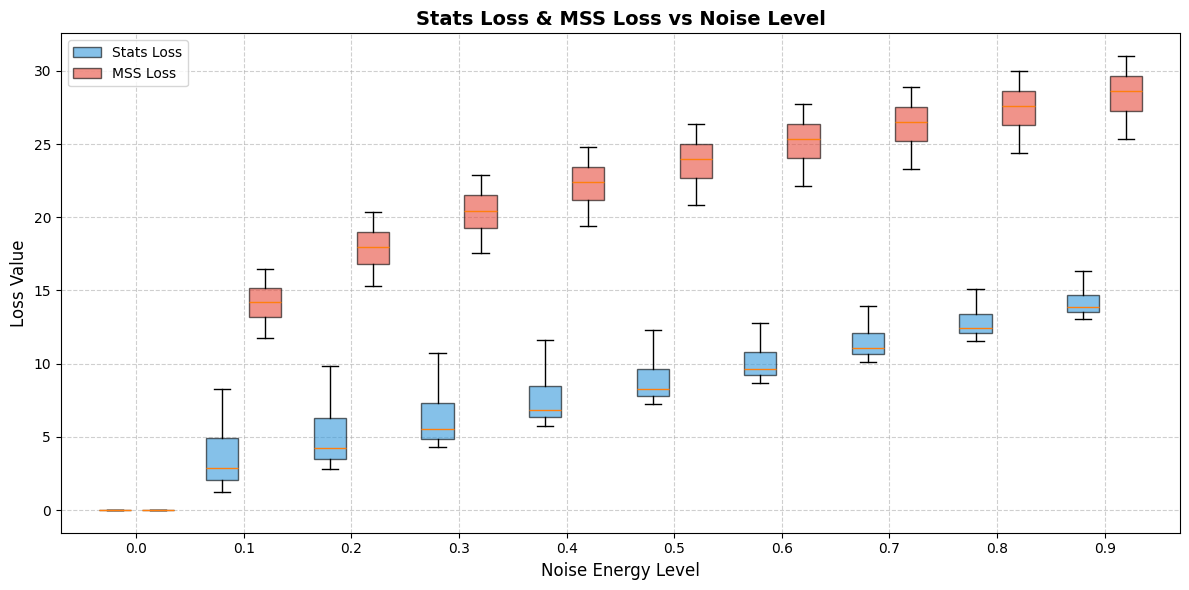

Processing ../../datasets/hand_curated/rain/rain.wav
+---------------+---------------------------+-------------------------+
|   Noise Level | Stats Loss (mean ± std)   | MSS Loss (mean ± std)   |
+===============+===========================+=========================+
|        0.0000 | 0.0000 ± 0.0000           | 0.0000 ± 0.0000         |
+---------------+---------------------------+-------------------------+
|        0.1000 | 0.1840 ± 0.0451           | 3.4086 ± 0.2704         |
+---------------+---------------------------+-------------------------+
|        0.2000 | 0.6591 ± 0.1414           | 4.7226 ± 0.3689         |
+---------------+---------------------------+-------------------------+
|        0.3000 | 1.3558 ± 0.2493           | 5.7459 ± 0.4441         |
+---------------+---------------------------+-------------------------+
|        0.4000 | 2.2126 ± 0.3518           | 6.6266 ± 0.5133         |
+---------------+---------------------------+-------------------------+
|        0.

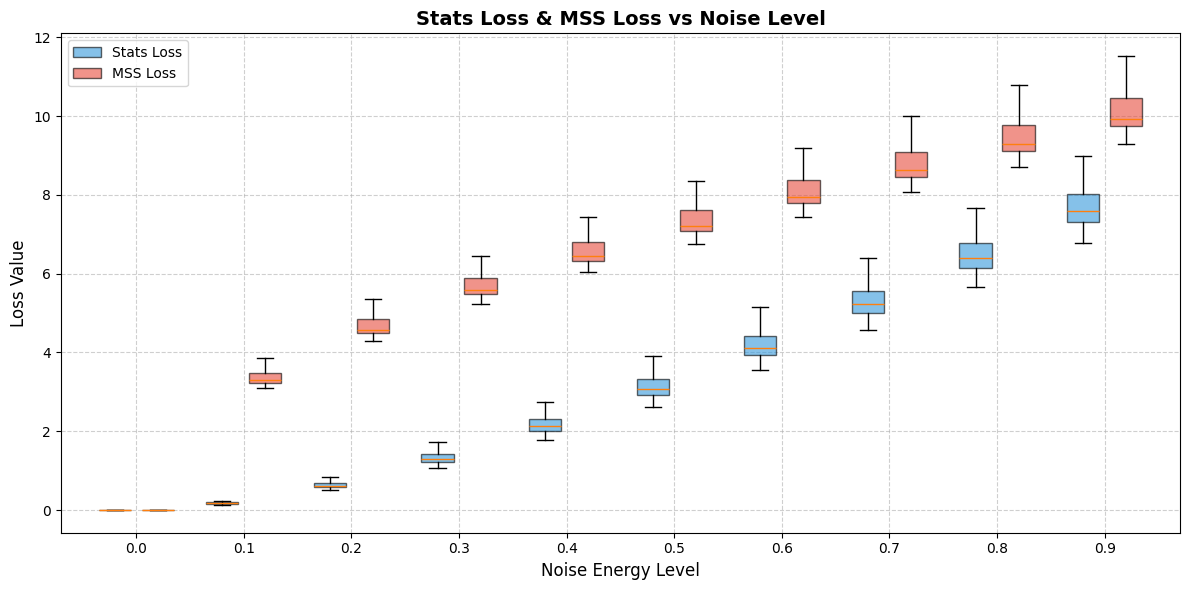

Processing ../../datasets/hand_curated/bubbles/bubbles.wav
+---------------+---------------------------+-------------------------+
|   Noise Level | Stats Loss (mean ± std)   | MSS Loss (mean ± std)   |
+===============+===========================+=========================+
|        0.0000 | 0.0000 ± 0.0000           | 0.0000 ± 0.0000         |
+---------------+---------------------------+-------------------------+
|        0.1000 | 2.5293 ± 0.3284           | 8.9308 ± 0.4034         |
+---------------+---------------------------+-------------------------+
|        0.2000 | 3.4848 ± 0.2708           | 12.1120 ± 0.4766        |
+---------------+---------------------------+-------------------------+
|        0.3000 | 4.6118 ± 0.2141           | 14.2904 ± 0.5168        |
+---------------+---------------------------+-------------------------+
|        0.4000 | 5.8480 ± 0.1759           | 16.0030 ± 0.5432        |
+---------------+---------------------------+-------------------------+
|    

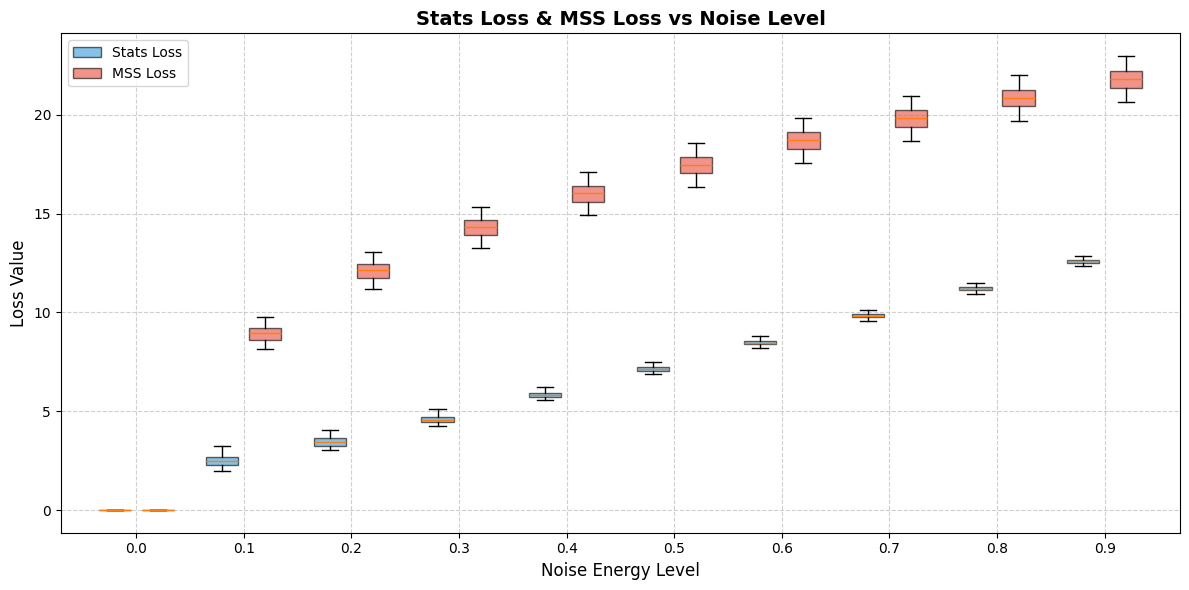

Done!


In [4]:
# paths of all files in a directory recursively
def get_all_files(path):
    all_files = []
    for root, dirs, files in os.walk(path):
        for file in files:
            all_files.append(os.path.join(root, file))
    return all_files

for file_path in get_all_files("../../datasets/hand_curated/"):
    if file_path.endswith(".wav"):
        print(f"Processing {file_path}")
        # Call the experiment function
        experiment_noise(file_path)

print("Done!")

In [5]:
# Assuming texstat_loss and multiscale_spectrogram_loss are defined elsewhere
def experiment_time_shift(audio_path):
    # Device selection
    device = "cuda" if torch.cuda.is_available() else "cpu"

    # Load audio
    y, sr = librosa.load(audio_path, sr=44100, mono=True)

    # Parameters for TexStat
    sr, frame_size = 44100, 2**16
    N_filter_bank = 16
    M_filter_bank = 6
    N_moments = 4
    alpha = torch.tensor([100, 1, 1/10, 1/100], device=device)
    beta = torch.tensor([1, 1, 1, 1, 1], device=device)
    new_sr, new_frame_size = sr // 4, frame_size // 4
    downsampler = torchaudio.transforms.Resample(sr, new_sr).to(device)
    coch_fb = fb.EqualRectangularBandwidth(frame_size, sr, N_filter_bank, 20, sr // 2)
    mod_fb  = fb.Logarithmic(new_frame_size, new_sr, M_filter_bank, 10, new_sr // 4)

    # Make batch of 100 random segments
    segments = []
    for _ in range(100):
        start = np.random.randint(0, len(y) - frame_size)
        segment = y[start:start + frame_size]
        segment = (segment - np.mean(segment)) / np.std(segment)
        segments.append(segment)
    segments = torch.tensor(segments, device=device)

    # Store losses for boxplot
    stats_losses = []
    mss_losses = []
    shift_levels = [frame_size * i // 10 for i in range(10)]  # Shift steps
    stats_mean_std = []
    mss_mean_std = []

    for shift in shift_levels:
        stats_loss_i = []
        mss_loss_i = []
        segments_shifted = torch.roll(segments, shifts=shift, dims=1)  # Shift in time

        for i in range(100):
            segment_local = segments[i]
            segment_shifted_local = segments_shifted[i]

            stats_loss_local = texstat_loss(segment_local, segment_shifted_local, coch_fb, mod_fb, downsampler, N_moments, alpha, beta)
            mss_loss_local   = multiscale_spectrogram_loss(segment_local, segment_shifted_local)

            stats_loss_i.append(stats_loss_local.item())
            mss_loss_i.append(mss_loss_local.item())

        stats_losses.append(stats_loss_i)
        mss_losses.append(mss_loss_i)

        # Calculate mean and std for each shift level
        stats_mean_std.append(f"{np.mean(stats_loss_i):.4f} ± {np.std(stats_loss_i):.4f}")
        mss_mean_std.append(f"{np.mean(mss_loss_i):.4f} ± {np.std(mss_loss_i):.4f}")

    # Create side-by-side boxplots **without outliers**
    plt.figure(figsize=(12, 6))

    # Boxplot for stats loss (no fliers)
    box1 = plt.boxplot(stats_losses, positions=np.arange(len(shift_levels)) - 0.2, widths=0.3, 
                        patch_artist=True, boxprops=dict(facecolor="#3498db", alpha=0.6),
                        showfliers=False)

    # Boxplot for MSS loss (no fliers)
    box2 = plt.boxplot(mss_losses, positions=np.arange(len(shift_levels)) + 0.2, widths=0.3, 
                        patch_artist=True, boxprops=dict(facecolor="#e74c3c", alpha=0.6),
                        showfliers=False)

    # Labels and styling
    plt.xticks(range(len(shift_levels)), [f"{shift/frame_size:.1f}" for shift in shift_levels])
    plt.xlabel("Time Shift (fraction of frame_size)", fontsize=12)
    plt.ylabel("Loss Value", fontsize=12)
    plt.title("Stats Loss & MSS Loss vs Time Shift", fontsize=14, fontweight="bold")
    plt.grid(True, linestyle="--", alpha=0.6)

    # Add legend manually
    plt.legend([box1["boxes"][0], box2["boxes"][0]], ["Stats Loss", "MSS Loss"], loc="upper left")

    # Show boxplots
    plt.tight_layout()

    # Create table of mean ± std values
    table_data = []
    for i, shift in enumerate(shift_levels):
        table_data.append([f"{shift/frame_size:.1f}", stats_mean_std[i], mss_mean_std[i]])

    # Display the table
    table_header = ["Time Shift (fraction of frame_size)", "Stats Loss (mean ± std)", "MSS Loss (mean ± std)"]
    table_str = tabulate(table_data, headers=table_header, tablefmt="grid", floatfmt=".4f")

    print(table_str)

    # Show plot
    plt.show()


Processing ../../datasets/hand_curated/keyboard/keyboard.wav
+---------------------------------------+---------------------------+-------------------------+
|   Time Shift (fraction of frame_size) | Stats Loss (mean ± std)   | MSS Loss (mean ± std)   |
+=======================================+===========================+=========================+
|                                0.0000 | 0.0000 ± 0.0000           | 0.0000 ± 0.0000         |
+---------------------------------------+---------------------------+-------------------------+
|                                0.1000 | 0.0289 ± 0.0158           | 9.4893 ± 0.6088         |
+---------------------------------------+---------------------------+-------------------------+
|                                0.2000 | 0.0286 ± 0.0165           | 9.6847 ± 0.6067         |
+---------------------------------------+---------------------------+-------------------------+
|                                0.3000 | 0.0276 ± 0.0160           | 9.844

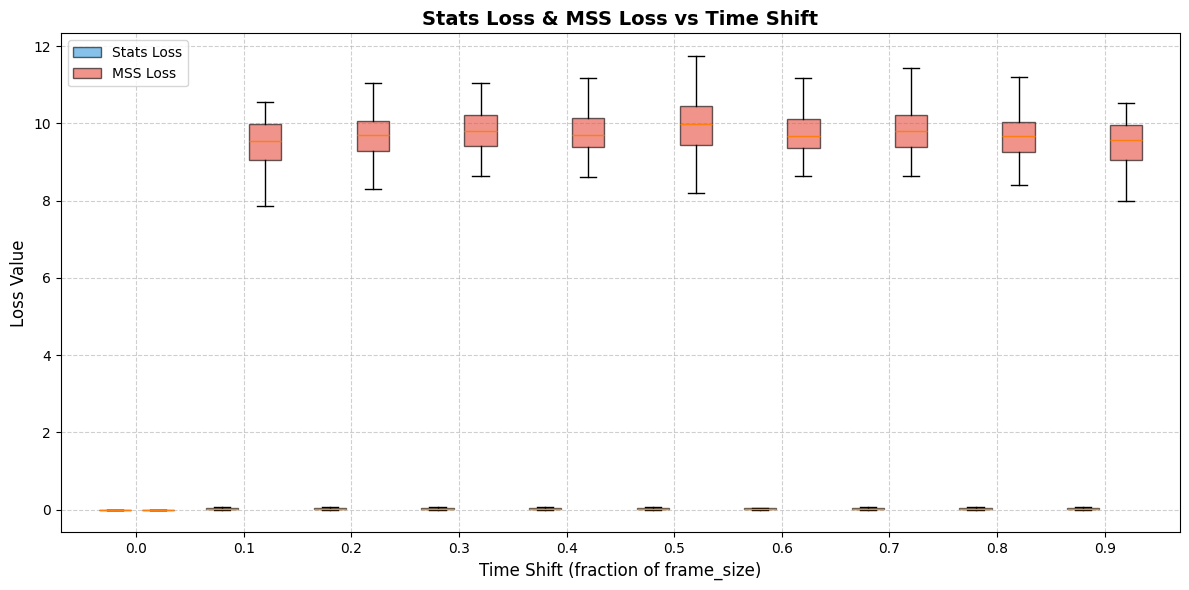

Processing ../../datasets/hand_curated/water/water.wav
+---------------------------------------+---------------------------+-------------------------+
|   Time Shift (fraction of frame_size) | Stats Loss (mean ± std)   | MSS Loss (mean ± std)   |
+=======================================+===========================+=========================+
|                                0.0000 | 0.0000 ± 0.0000           | 0.0000 ± 0.0000         |
+---------------------------------------+---------------------------+-------------------------+
|                                0.1000 | 0.0156 ± 0.0056           | 5.6526 ± 0.0504         |
+---------------------------------------+---------------------------+-------------------------+
|                                0.2000 | 0.0152 ± 0.0066           | 5.6608 ± 0.0451         |
+---------------------------------------+---------------------------+-------------------------+
|                                0.3000 | 0.0152 ± 0.0057           | 5.6633 ± 0.

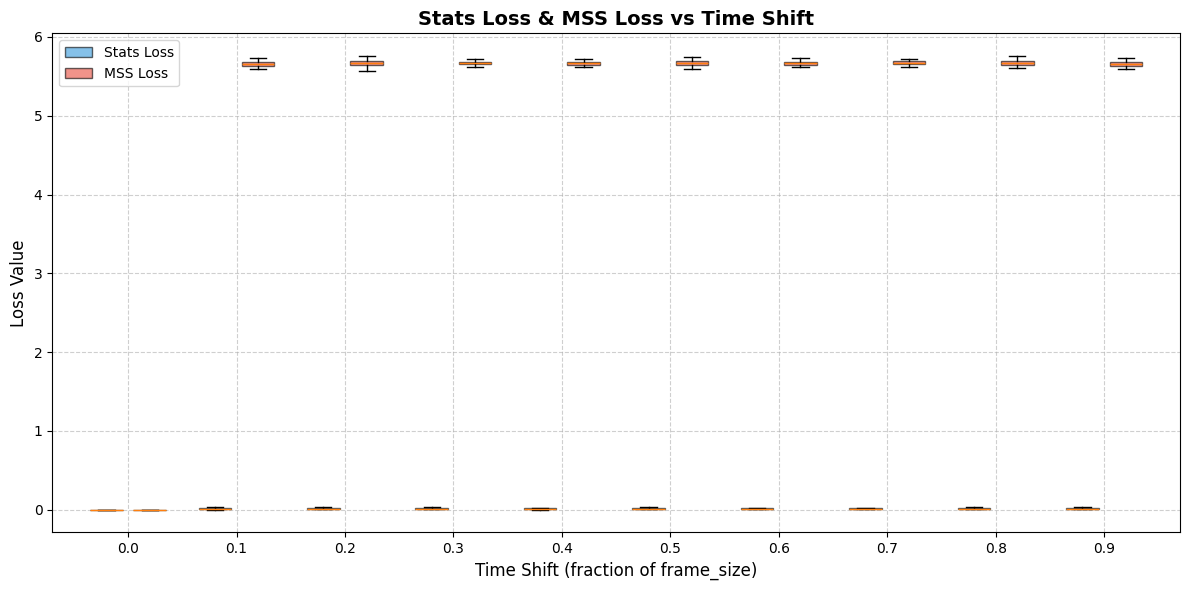

Processing ../../datasets/hand_curated/wind/wind.wav
+---------------------------------------+---------------------------+-------------------------+
|   Time Shift (fraction of frame_size) | Stats Loss (mean ± std)   | MSS Loss (mean ± std)   |
+=======================================+===========================+=========================+
|                                0.0000 | 0.0000 ± 0.0000           | 0.0000 ± 0.0000         |
+---------------------------------------+---------------------------+-------------------------+
|                                0.1000 | 0.0576 ± 0.0345           | 4.6996 ± 0.0370         |
+---------------------------------------+---------------------------+-------------------------+
|                                0.2000 | 0.0580 ± 0.0349           | 4.7425 ± 0.0607         |
+---------------------------------------+---------------------------+-------------------------+
|                                0.3000 | 0.0577 ± 0.0343           | 4.7918 ± 0.07

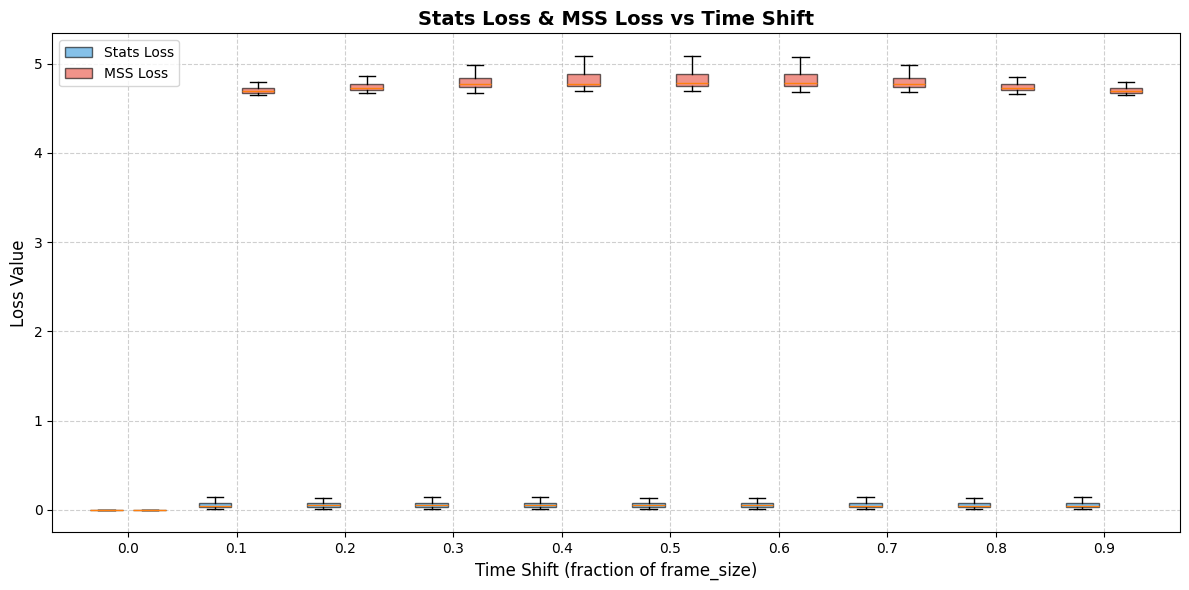

Processing ../../datasets/hand_curated/fire/fire.wav
+---------------------------------------+---------------------------+-------------------------+
|   Time Shift (fraction of frame_size) | Stats Loss (mean ± std)   | MSS Loss (mean ± std)   |
+=======================================+===========================+=========================+
|                                0.0000 | 0.0000 ± 0.0000           | 0.0000 ± 0.0000         |
+---------------------------------------+---------------------------+-------------------------+
|                                0.1000 | 0.0504 ± 0.0335           | 6.0719 ± 0.6754         |
+---------------------------------------+---------------------------+-------------------------+
|                                0.2000 | 0.0491 ± 0.0337           | 6.1301 ± 0.7068         |
+---------------------------------------+---------------------------+-------------------------+
|                                0.3000 | 0.0490 ± 0.0327           | 6.1539 ± 0.72

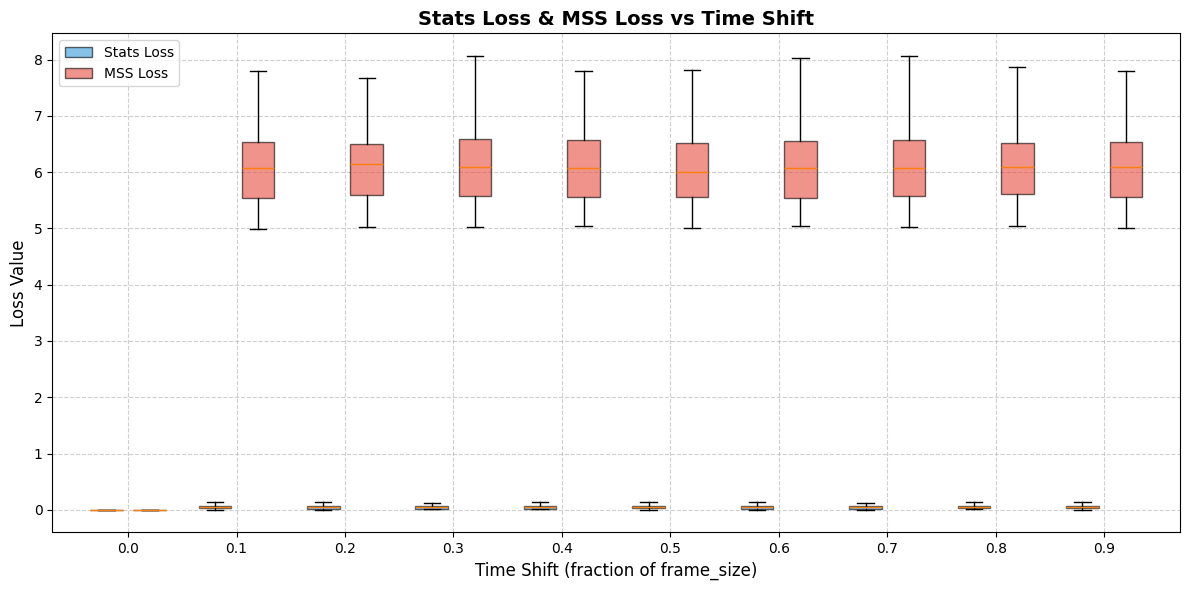

Processing ../../datasets/hand_curated/rain/rain.wav
+---------------------------------------+---------------------------+-------------------------+
|   Time Shift (fraction of frame_size) | Stats Loss (mean ± std)   | MSS Loss (mean ± std)   |
+=======================================+===========================+=========================+
|                                0.0000 | 0.0000 ± 0.0000           | 0.0000 ± 0.0000         |
+---------------------------------------+---------------------------+-------------------------+
|                                0.1000 | 0.0169 ± 0.0077           | 6.6911 ± 0.1952         |
+---------------------------------------+---------------------------+-------------------------+
|                                0.2000 | 0.0166 ± 0.0075           | 6.6867 ± 0.2106         |
+---------------------------------------+---------------------------+-------------------------+
|                                0.3000 | 0.0167 ± 0.0076           | 6.6629 ± 0.20

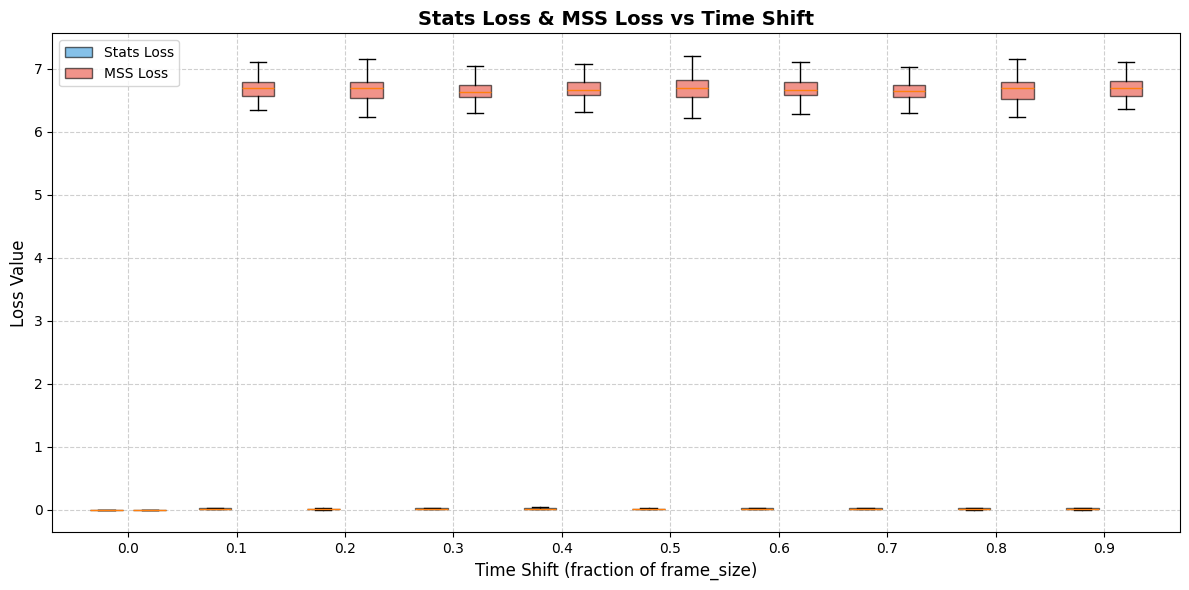

Processing ../../datasets/hand_curated/bubbles/bubbles.wav
+---------------------------------------+---------------------------+-------------------------+
|   Time Shift (fraction of frame_size) | Stats Loss (mean ± std)   | MSS Loss (mean ± std)   |
+=======================================+===========================+=========================+
|                                0.0000 | 0.0000 ± 0.0000           | 0.0000 ± 0.0000         |
+---------------------------------------+---------------------------+-------------------------+
|                                0.1000 | 0.0251 ± 0.0122           | 7.4080 ± 0.1644         |
+---------------------------------------+---------------------------+-------------------------+
|                                0.2000 | 0.0228 ± 0.0113           | 7.4130 ± 0.1934         |
+---------------------------------------+---------------------------+-------------------------+
|                                0.3000 | 0.0239 ± 0.0108           | 7.4165 

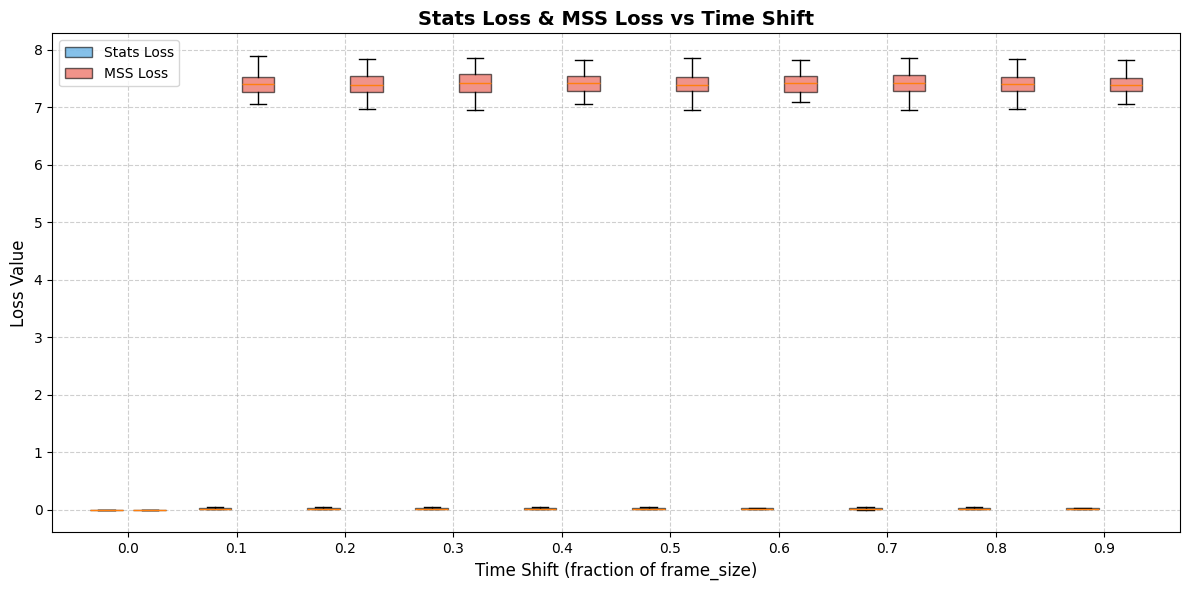

Done!


In [6]:
# paths of all files in a directory recursively
def get_all_files(path):
    all_files = []
    for root, dirs, files in os.walk(path):
        for file in files:
            all_files.append(os.path.join(root, file))
    return all_files

for file_path in get_all_files("../../datasets/hand_curated/"):
    if file_path.endswith(".wav"):
        print(f"Processing {file_path}")
        # Call the experiment function
        experiment_time_shift(file_path)

print("Done!")